In [1]:
import tensorflow as tf
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  1


In [ ]:
load the data

In [17]:
import pandas as pd

digits_training_data = pd.read_csv('./train.csv')

# X is all the features I will be training the dataset on 
X = digits_training_data.copy()
# y is the prediction target
# pop label from the X and at the same time set the target
y = X.pop('label')

# X.head()
# y.head()

In [24]:
from sklearn.model_selection import train_test_split

# use part of the data from training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

In [30]:
X_train = (digits_training_data.iloc[:,1:].values).astype('float32') # all pixel values
y_train = digits_training_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits

test= pd.read_csv("./test.csv")
X_test = test.values.astype('float32')

In [32]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape


X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

# input_shape is the shape of the input data
model = keras.Sequential([
    layers.BatchNormalization(input_shape=(28,28,1)),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation='softmax'),
])

In [47]:
import numpy as np # linear algebra

mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

model= keras.Sequential()
model.add(keras.layers.Lambda(standardize,input_shape=(28,28,1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

Epoch 1/1000
329/329 [==============================] - 1s 3ms/step - loss: 27.3208 - accuracy: 0.0970 - val_loss: 27.3198 - val_accuracy: 0.1007
Epoch 2/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3194 - accuracy: 0.0983 - val_loss: 27.3195 - val_accuracy: 0.1057
Epoch 3/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3192 - accuracy: 0.0987 - val_loss: 27.3194 - val_accuracy: 0.0912
Epoch 4/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3192 - accuracy: 0.1012 - val_loss: 27.3194 - val_accuracy: 0.1109
Epoch 5/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3192 - accuracy: 0.1039 - val_loss: 27.3194 - val_accuracy: 0.0956
Epoch 6/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3191 - accuracy: 0.1028 - val_loss: 27.3193 - val_accuracy: 0.0861
Epoch 7/1000
329/329 [==============================] - 1s 2ms/step - loss: 27.3191 - accuracy: 0.1031 - val_loss: 27.3193 -

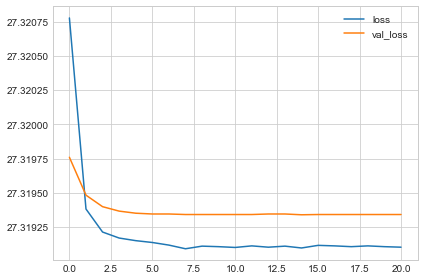

In [49]:
# min_delta is the minimum change in the monitored quantity to qualify as an improvement, which is used for early stopping.
# patience is the number of epochs with no improvement after which training will be stopped.

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

optimizer = keras.optimizers.Adam(lr=0.001)
# optimizer is the algorithm used to update the weights of the model.
# loss is the loss function to be minimized by the model.
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# batch size is the number of samples (rows) that will be processed at a time
# epochs is the number of times the entire dataset will be processed
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=1000,
    callbacks=[early_stopping],
)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [66]:
digits_training_data = pd.read_csv('./test.csv')
test_X = digits_training_data.copy()

prediction = model.predict(test_X)
print(prediction)
# output = pd.DataFrame({'imageId': digits_training_data.Id,
#                        'Label': prediction})
# output.to_csv('submission.csv', index=False)
# X.head()
# y.head()

[[ 2.0077026e+00  2.0129826e+00  2.0684195e+00 ...  1.9764564e+00
   2.0132022e+00  2.0348270e+00]
 [ 3.8989097e-02 -3.9773285e-03  4.3908805e-02 ...  3.4170955e-02
   2.3760825e-02  9.8784268e-03]
 [ 8.6154547e+00  8.5921335e+00  8.6504059e+00 ...  8.5916328e+00
   8.6018906e+00  8.5951900e+00]
 ...
 [ 2.9972768e+00  2.9869580e+00  2.9756510e+00 ...  3.0247433e+00
   3.0139720e+00  2.9805217e+00]
 [ 8.8540974e+00  8.8596172e+00  8.8412752e+00 ...  8.8488369e+00
   8.8472795e+00  8.8568516e+00]
 [ 1.9845892e+00  1.9789348e+00  2.0581381e+00 ...  1.9398361e+00
   1.9858190e+00  2.0114005e+00]]
